In [1]:
import sys, os
sys.path.append('../src')
import numpy as np
from scipy import interpolate
from numba import jit, float64
import time, multiprocessing, pickle
from U1Funcs import DMvRatesGen
from StatisticFuncs import *
from WIMPFuncs import C_SI
from Params import *
from U1PlotFuncs import *

In [2]:
#========================== Experimental setup =========================================#
ne = 10 # number of energy bins
E_th = 1*1e-6 # Threshold GeV
E_max = 5*1e-6 # Max recoil energy GeV
Nuc = Xe131
#========================== Initialize fog =========================================#
fogGen=Fog()
#========================== Model and other parameters =================================#
selList=np.array([0,1,3])
b0Level=0.
mDM = 5.5

In [3]:
modelParaList = [[np.log10(2e-5),np.log10(30e-3),1,1,1],\
    [np.log10(4e-5),np.log10(20e-3),1/3,1/3,-1], [np.log10(8e-4),np.log10(16e-3),[0,1,-1]]]
paraGenList = [StatisticClass(SpectrumNR(mDM, E_th, E_max, ne, Nuc,modelParaList[0],selList),'SMvsDMNP'),\
               StatisticClass(SpectrumNR(mDM, E_th, E_max, ne, Nuc,modelParaList[1],selList),'DMvsNP'),\
               StatisticClass(SpectrumNR(mDM, E_th, E_max, ne, Nuc,modelParaList[2],selList,mode='FD'),'DMvsNP')]

[['0' 'hep']
 ['1' '8B']
 ['2' 'DSNB']
 ['3' 'Atm']
 ['4' 'Reactor']]
[['0' 'hep']
 ['1' '8B']
 ['2' 'DSNB']
 ['3' 'Atm']
 ['4' 'Reactor']]
[['0' 'hep']
 ['1' '8B']
 ['2' 'DSNB']
 ['3' 'Atm']
 ['4' 'Reactor']]


In [4]:
def contourGen(paraGenClass, FogGenClass):
    mDMList = np.logspace(-1,np.log10(10),400)
    mDMList=DMvRatesGen(mDMList, E_th, E_max, ne, Nuc, C_SI)[0]
    exposureEndLog, dExpoLog, CL, b0Level = 8., 0.1, 0.9, 0.
    paraGenClass.setDMMass(mDM)
    NPDiscoveryExposure = biSearch(1., 8, findNPDiscoveryExposure, [paraGenClass, CL, b0Level], 0., 0)[0]
    print(NPDiscoveryExposure)
    paraList = exposureEndLog, dExpoLog, CL, b0Level, NPDiscoveryExposure
    res=resGen(mDMList,paraGenClass, FogGenClass,paraList)
    #return vsContourDatGen(res[0], res[1])
    return res

In [5]:
resList1 = [contourGen(paraGenList[i],fogGen) for i in range(3)]

0.05859375


100%|██████████| 102/102 [01:35<00:00,  1.06it/s]


Time costed: 106.07952629984356 s.
-0.74609375


100%|██████████| 102/102 [01:59<00:00,  1.17s/it]


Time costed: 133.19529490009882 s.
0.66796875


100%|██████████| 102/102 [01:58<00:00,  1.16s/it]


Time costed: 130.4404853999149 s.


In [6]:
resList = resList1
colorList = ['r', 'b', 'g']
labelList = [r'U(1)$_{\rm Universal}$', r'U(1)$_{B-L}$',r'U(1)$_{L_\mu-L_\tau}$']

In [7]:
def ax1Func(ax1, dat, color, label=False, topLabel=False):
    n = 5
    colors = np.zeros([n,4])
    colors[0] = mpl.colors.to_rgba(color)
    colors[:] = mpl.colors.to_rgba(color)
    colors[:,3] = [0., 0.2, 0.4, 0.6, 0.8]
    cmap = mpl.colors.ListedColormap(colors, name='test')
    m,sig,n = vsContourDatGen(dat[0], dat[1])
    cnt = ax1.contourf(m,sig,n,np.array([0.,1., 5., 10., 100., 10000.]),\
                       colors=colors,antialiased=True)
    for c in cnt.collections:
        c.set_edgecolor("face")
    if label:
        ax1.fill_between([-2,-1],[1,1],[2,2],color=color,alpha=0.5,label=label)
    if topLabel:
        cmap2 = mpl.colors.ListedColormap(colors[1:-1], name='test')
        cmap2.set_under(color=color, alpha=0.)
        cmap2.set_over(color=color, alpha=1.)
        im = plt.pcolormesh(-m,sig,n,vmax=4.,vmin=1,cmap=cmap2,rasterized=True,shading='auto')
        fig.subplots_adjust(top=0.8)
        cbar_ax = fig.add_axes([0.1, 0.82, 0.82, 0.02])
        cbar = fig.colorbar(im, cax=cbar_ax,orientation='horizontal',extend='max',extendfrac=0.03, \
                     ticks=[1,2,3,4])
        cbar.set_ticklabels([1,5,10,100])
        cbar_ax.xaxis.set_ticks_position('top')
        plt.gcf().text(0.5,0.883,r'$n = {\rm Exposure}_{\rm Distinction}/{\rm Exposure}_{\rm Discovery}$',fontsize=22,ha='center')

LimitPlotFunc = MakeLimitPlot_DMNSI

C:\Users\ALoong\AppData\Local\Temp\ipykernel_31760\1756964306.py:11: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in cnt.collections:


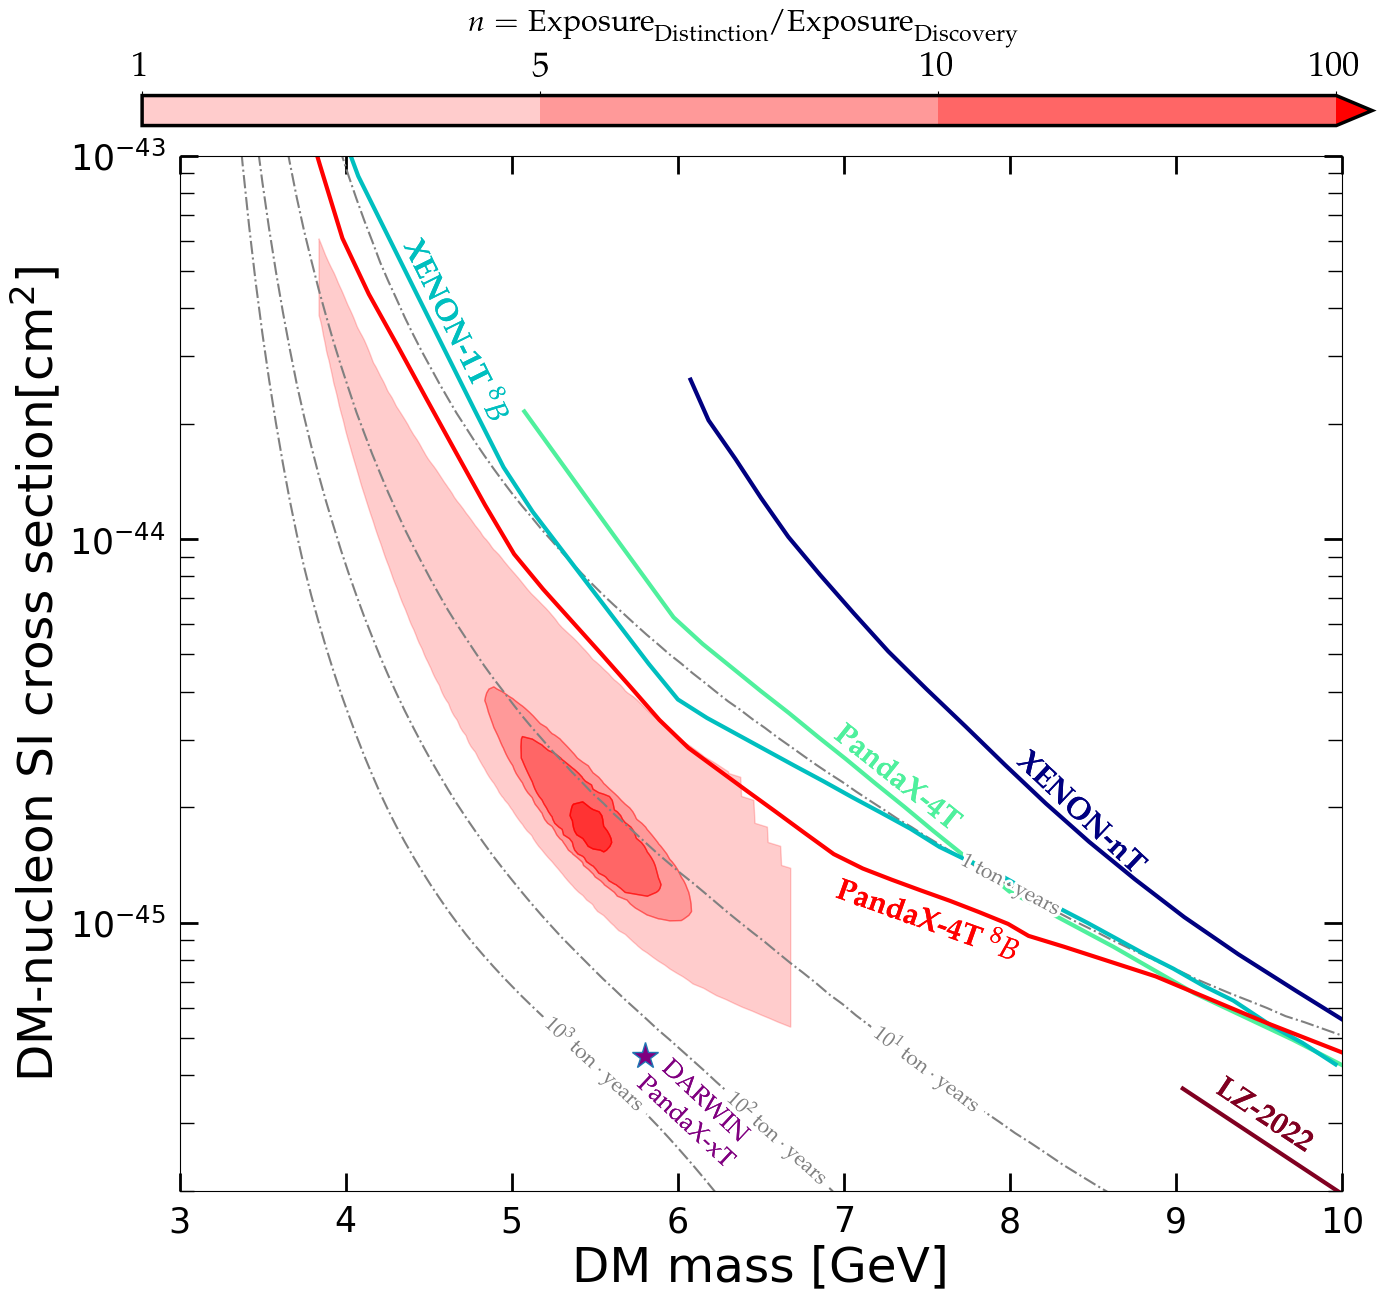

In [8]:
fig, ax1 = plt.subplots(figsize=(15,15))
# Plot style
lw, tfs = 2.5, 25
lfs = 35
plt.rcParams['axes.linewidth'] = lw
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=tfs)
mpl.rcParams['text.latex.preamble'] = r'\usepackage{mathpazo}'
#========================== exposure lines =================================================#
expoLogList = np.linspace(-1,2,4)
sigma0ContourList = 10**np.transpose([np.interp(expoLogList, d[1][1], d[1][0]) for d in resList[2][1]])
expoLogLabelList = [r"$1$ ${\rm ton}\cdot {\rm years}$"]+[r"$10^"+str(i)+r"$ ${\rm ton}\cdot {\rm years}$" \
                                                          for i in range(1,4)]
DMMassList=resList[2][0]
lines=[]
for i in range(len(expoLogList)):
    l1 = ax1.semilogy(DMMassList, sigma0ContourList[i], c='gray', linestyle='-.', label=expoLogLabelList[i])
    lines.extend(l1)
labelLines([lines[0]], xvals=[8], fontsize=15, outline_width=5)
labelLines(lines[1:], xvals=[7.5,6.6,5.5], fontsize=15, outline_width=13)

sigma0ContourDARWIN = 10**np.array([np.interp(np.log10(20), d[1][1], d[1][0]) for d in resList[2][1]])
ax1.plot(5.8,np.interp(5.8,DMMassList,sigma0ContourDARWIN),'*',markersize=20,mfc='purple')
l1 = ax1.semilogy(DMMassList,sigma0ContourDARWIN, c=[0,0,0,0], linestyle='-.', label="DARWIN\nPandaX-xT")
labelLines(l1, xvals=6.1, color='purple',fontsize=18, outline_width=0,drop_label=True, yoffsets=-2e-47)
#========================== limits =======================================================#
ax1, lines=LimitPlotFunc(ax1,xmin=3.0e0,xmax=1e1,ymin=2e-46,ymax=1e-43,\
             facecolor='darkgray',edgecolor='darkgray',edgecolor_collected='darkgray',\
             alph=0.5,lfs=35,tfs=25)
labelLines([lines[-1]], xvals=[7.5], fontsize=22,outline_color=[1,0,0,0], yoffsets=-2e-46)
labelLines(lines[:-1], xvals=[8,6.9,9.2,4.3], fontsize=22,outline_color=[1,0,0,0],ha="left",va="bottom")
#========================== contour plot =================================================#
dat = resList[0]
color = colorList[0]
ax1Func(ax1, dat, color, label=False, topLabel=True)
#=========================== labels ===================================================#
ax1.set_xlabel(r"DM mass [GeV]",fontsize=lfs)
ax1.set_ylabel(r"DM-nucleon SI cross section[cm$^2$]",fontsize=lfs)
ax1.tick_params(which='major',direction='in',width=2,length=13,right=True,top=True,pad=10,labelsize=25)
ax1.tick_params(which='minor',direction='in',width=1,length=10,right=True,top=True)

In [9]:
def ax23Func(plotPara, resDat):
    ax2, ax3, xExposureMax, sigma0A, sigma0B, expoPlotMinLog = plotPara
    sigma0LogList, exposureLogList, vsSigma0LogList, \
            vsExposureLogList, y, DistinctionSigmaLog = resDat

    DistinctionSigmaLog2 = findroot([vsSigma0LogList,y-1.])
    print('bounds: ',DistinctionSigmaLog,' ',DistinctionSigmaLog2)
    if len(DistinctionSigmaLog2) ==2:
        DistinctionSigmaLog = DistinctionSigmaLog2
    
    exposureList = 10**(exposureLogList[exposureLogList<xExposureMax])
    sigma0List = 10**(sigma0LogList[:len(exposureList)])
    ax3.loglog(sigma0List[::-1],10*exposureList[::-1],lw=3,color='r',linestyle='--')
    #print([sigma0List[::-1],exposureList[::-1]])
    ax3.axvline(10**(DistinctionSigmaLog[0]),lw=3,color='r',linestyle='--',alpha=0.3)
    ax3.axvline(10**(DistinctionSigmaLog[1]),lw=3,color='r',linestyle='--',alpha=0.3)
    
    ax3vsx = np.linspace(DistinctionSigmaLog[0],DistinctionSigmaLog[1],50)
    ax3vsy = np.interp(ax3vsx, vsSigma0LogList[::-1], vsExposureLogList[::-1])
    ax3.loglog(10**ax3vsx,10*(10**ax3vsy),lw=3,color='r',linestyle='-')
    
    vsSigma0LogList = vsSigma0LogList[::-1]
    y = y[::-1]
    ax2.loglog(10**(vsSigma0LogList[::-1]),y,lw=3,color='r')
    ax2.axvline(10**(DistinctionSigmaLog[0]),lw=3,color='r',linestyle='--',alpha=0.3)
    ax2.axvline(10**(DistinctionSigmaLog[1]),lw=3,color='r',linestyle='--',alpha=0.3)
    ax2.axhline(1,lw=2,color='gray',linestyle='--',alpha=0.5)
    
    ax3.plot(sigma0A,expoPlotMinLog,'wo',markersize=30,mfc='b',mec='k',mew=3,zorder=10)
    ax3.plot(sigma0B,expoPlotMinLog,'wo',markersize=30,mfc='b',mec='k',mew=3,zorder=10)
    
    ax3.text(sigma0A*(1+0.02),expoPlotMinLog,'a',color='w',fontsize=23,ha='center',va='center',zorder=10)
    ax3.text(sigma0B,expoPlotMinLog,'b',color='w',fontsize=23,ha='center',va='center',zorder=10)
    return ax2, ax3

def ax2Func(plotPara, resDat, color, line):
    ax2, ax3, xExposureMax, sigma0A, sigma0B, expoPlotMinLog = plotPara
    sigma0LogList, exposureLogList, vsSigma0LogList, \
            vsExposureLogList, y, DistinctionSigmaLog = resDat
    ax2.loglog(10**(vsSigma0LogList[::-1]),y[::-1],lw=3,color=color,linestyle=line)
    return ax2, ax3

C:\Users\ALoong\AppData\Local\Temp\ipykernel_31760\1756964306.py:11: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in cnt.collections:
C:\Users\ALoong\AppData\Local\Temp\ipykernel_31760\1678726415.py:13: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax3.loglog(sigma0List[::-1],10*exposureList[::-1],lw=3,color='r',linestyle='--')


bounds:  [-44.34166402 -44.9531036 ]   [-44.31414627469621, -44.953768142712285]


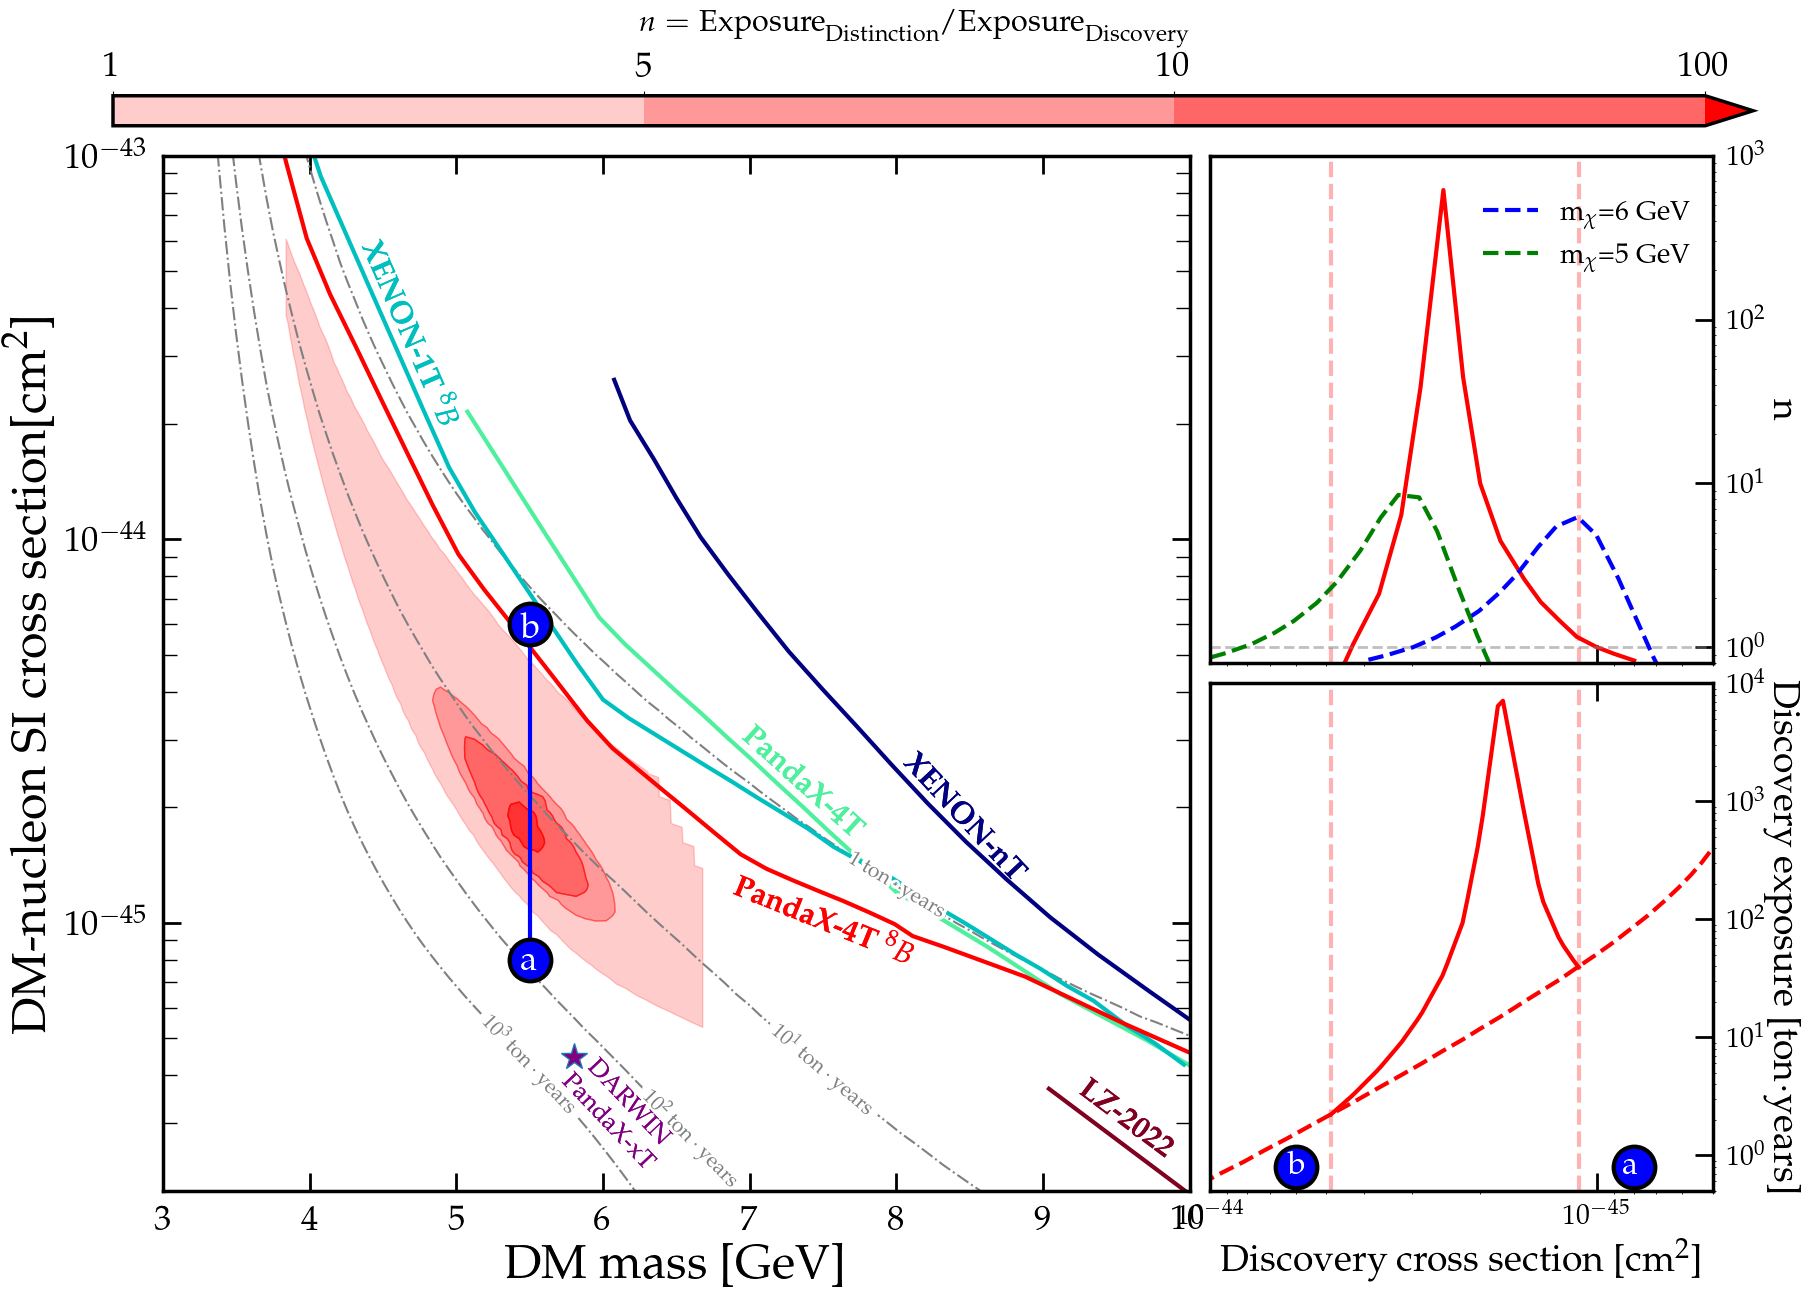

In [10]:
resListUniversal = resList[0]
#========================== plot canva =====================================================#
fig = plt.figure(figsize=(20,15))
gs = gridspec.GridSpec(2, 3)
gs.update(wspace=0.04)
gs.update(hspace=0.04)
ax1 = plt.subplot(gs[:,0:2])
ax2 = plt.subplot(gs[0,-1])
ax3 = plt.subplot(gs[1,-1])
#========================== plot style =====================================================#
lw, tfs = 2.5, 25
lfs = 35
plt.rcParams['axes.linewidth'] = lw
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=tfs)
mpl.rcParams['text.latex.preamble'] = r'\usepackage{mathpazo}'
#========================== ax1 ============================================================#
#========================== exposure lines =================================================#
expoLogList = np.linspace(-1,2,4)
sigma0ContourList = 10**np.transpose([np.interp(expoLogList, d[1][1], d[1][0]) for d in resList[2][1]])
expoLogLabelList = [r"$1$ ${\rm ton}\cdot {\rm years}$"]+[r"$10^"+str(i)+r"$ ${\rm ton}\cdot {\rm years}$" \
                                                          for i in range(1,4)]
DMMassList=resList[2][0]
lines=[]
for i in range(len(expoLogList)):
    l1 = ax1.semilogy(DMMassList, sigma0ContourList[i], c='gray', linestyle='-.', label=expoLogLabelList[i])
    lines.extend(l1)
labelLines([lines[0]], xvals=[8], fontsize=15, outline_width=5)
labelLines(lines[1:], xvals=[7.5,6.6,5.5], fontsize=15, outline_width=13)

sigma0ContourDARWIN = 10**np.array([np.interp(np.log10(20), d[1][1], d[1][0]) for d in resList[2][1]])
ax1.plot(5.8,np.interp(5.8,DMMassList,sigma0ContourDARWIN),'*',markersize=20,mfc='purple')
l1 = ax1.semilogy(DMMassList,sigma0ContourDARWIN, c=[0,0,0,0], linestyle='-.', label="DARWIN\nPandaX-xT")
labelLines(l1, xvals=6.1, color='purple',fontsize=18, outline_width=0,drop_label=True, yoffsets=-2e-47)
#========================== limits =======================================================#
ax1, lines=LimitPlotFunc(ax1,xmin=3.0e0,xmax=1e1,ymin=2e-46,ymax=1e-43,\
             facecolor='darkgray',edgecolor='darkgray',edgecolor_collected='darkgray',\
             alph=0.5,lfs=35,tfs=25)
labelLines([lines[-1]], xvals=[7.5], fontsize=22,outline_color=[1,0,0,0], yoffsets=-2e-46)
labelLines(lines[:-1], xvals=[8,6.9,9.2,4.3], fontsize=22,outline_color=[1,0,0,0],ha="left",va="bottom")
#========================== contour plot =================================================#
dat = resList[0]
color = colorList[0]
ax1Func(ax1, dat, color, label=False, topLabel=True)
#========================== example line =================================================#
m_example = 5.5
x1 = m_example
x2 = m_example
sigma0A = 8e-46
sigma0B = 6e-45
pek = line_background(6,'k')
ax1.plot([x1,x1],[sigma0A,sigma0B],color='blue',lw=3)
ax1.plot(x1,sigma0A,'wo',markersize=30,mfc='b',mec='k',mew=3)
ax1.plot(x2,sigma0B,'wo',markersize=30,mfc='b',mec='k',mew=3)
ax1.text(x1*(1+0.00),sigma0A*(1-0.01),'a',color='w',fontsize=25,ha='center',va='center')
ax1.text(x2,sigma0B*(1-0.03),'b',color='w',fontsize=25,ha='center',va='center')
#=========================== labels ===================================================#
ax1.set_xlabel(r"DM mass [GeV]",fontsize=lfs)
ax1.set_ylabel(r"DM-nucleon SI cross section[cm$^2$]",fontsize=lfs)
ax1.tick_params(which='major',direction='in',width=2,length=13,right=True,top=True,pad=10,labelsize=25)
ax1.tick_params(which='minor',direction='in',width=1,length=10,right=True,top=True)
#========================== ax2 ax3 ========================================================#
#========================== plot ======================================================#
expoPlotMinLog = 8.e-1
plotPara = ax2, ax3, 8., sigma0A, sigma0B, expoPlotMinLog
massList, resDat = resListUniversal[0], resListUniversal[1]
i = np.argmin(np.abs(massList-m_example))
ax23Func(plotPara,resDat[i][1])

i = np.argmin(np.abs(massList-6))
vsSigma0LogList, y = resDat[i][1][2], resDat[i][1][4]
ax2.semilogx(10**(vsSigma0LogList[::-1]),y[::-1],lw=3,color='b',linestyle='--',label=r'm$_\chi$=6 GeV')
i = np.argmin(np.abs(massList-5))
vsSigma0LogList, y = resDat[i][1][2], resDat[i][1][4]
ax2.semilogx(10**(vsSigma0LogList[::-1]),y[::-1],lw=3,color='g',linestyle='--',label=r'm$_\chi$=5 GeV')
#=========================== labels ===================================================#
ax2.legend(fontsize=20,frameon=True,loc=(0.52,0.75),framealpha=0)
ax23lfs=27
ax2.set_ylabel(r'n',fontsize=ax23lfs,rotation=-90,labelpad=25)
ax23xRange = [1e-44, 5e-46]
ax2.set_xlim(ax23xRange)
ax2.set_ylim([0.8,1e3])
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.tick_params(which='major',direction='in',width=2,length=13,\
                left=False,top=False,right=True,bottom=True,labelbottom=False,pad=10,labelsize=20)

ax3.set_xlabel(r"Discovery cross section [cm$^2$]",fontsize=ax23lfs)
ax3.set_ylabel(r"Discovery exposure [ton$\cdot$years]",fontsize=ax23lfs,rotation=-90,labelpad=25)
ax3.set_xlim(ax23xRange)
ax3.set_ylim([5e-1, 1e4])
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.tick_params(which='major',direction='in',width=2,length=13,\
                left=False,top=True,right=True,bottom=True,pad=10,labelsize=20)
#=====================================================================================#
p1 = fig

In [11]:
myPathFig = os.path.join(os.path.abspath(os.path.pardir),'plots')
p1.savefig(os.path.join(myPathFig,"DMNSISMvsDMNP"+'.pdf'),bbox_inches='tight')
p1.savefig(os.path.join(myPathFig,'png','DMNSISMvsDMNP.png'),bbox_inches='tight')

C:\Users\ALoong\AppData\Local\Temp\ipykernel_31760\1756964306.py:11: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in cnt.collections:
C:\Users\ALoong\AppData\Local\Temp\ipykernel_31760\1756964306.py:11: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in cnt.collections:


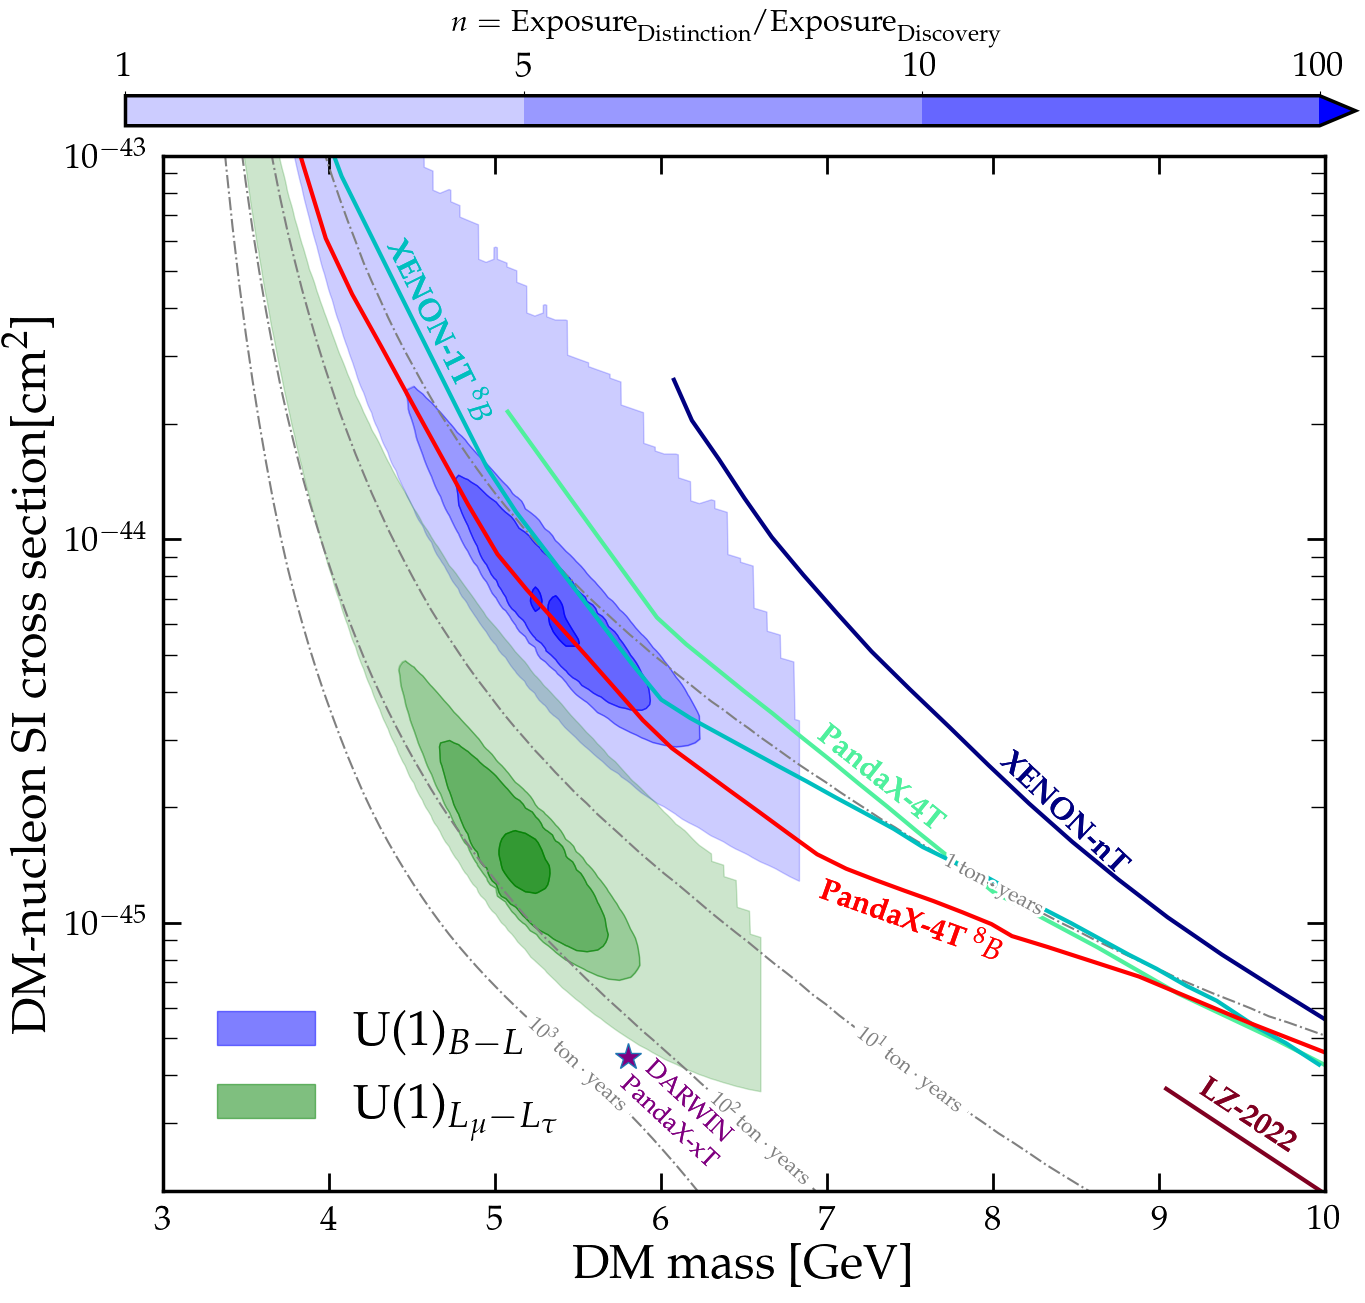

In [12]:
fig, ax1 = plt.subplots(figsize=(15,15))
# Plot style
lw, tfs = 2.5, 25
lfs = 35
plt.rcParams['axes.linewidth'] = lw
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=tfs)
mpl.rcParams['text.latex.preamble'] = r'\usepackage{mathpazo}'
#========================== exposure lines =================================================#
expoLogList = np.linspace(-1,2,4)
sigma0ContourList = 10**np.transpose([np.interp(expoLogList, d[1][1], d[1][0]) for d in resList[2][1]])
expoLogLabelList = [r"$1$ ${\rm ton}\cdot {\rm years}$"]+[r"$10^"+str(i)+r"$ ${\rm ton}\cdot {\rm years}$" \
                                                          for i in range(1,4)]
DMMassList=resList[2][0]
lines=[]
for i in range(len(expoLogList)):
    l1 = ax1.semilogy(DMMassList, sigma0ContourList[i], c='gray', linestyle='-.', label=expoLogLabelList[i])
    lines.extend(l1)
labelLines([lines[0]], xvals=[8], fontsize=15, outline_width=5,drop_label=True)
labelLines(lines[1:], xvals=[7.5,6.6,5.5], fontsize=15, outline_width=13,drop_label=True)

sigma0ContourDARWIN = 10**np.array([np.interp(np.log10(20), d[1][1], d[1][0]) for d in resList[2][1]])
ax1.plot(5.8,np.interp(5.8,DMMassList,sigma0ContourDARWIN),'*',markersize=20,mfc='purple')
l1 = ax1.semilogy(DMMassList,sigma0ContourDARWIN, c=[0,0,0,0], linestyle='-.', label="DARWIN\nPandaX-xT")
labelLines(l1, xvals=6.1, color='purple',fontsize=18, outline_width=0,drop_label=True, yoffsets=-2e-47)
#========================== limits =======================================================#
ax1, lines=LimitPlotFunc(ax1,xmin=3.0e0,xmax=1e1,ymin=2e-46,ymax=1e-43,\
             facecolor='darkgray',edgecolor='darkgray',edgecolor_collected='darkgray',\
             alph=0.5,lfs=35,tfs=25)
labelLines([lines[-1]], xvals=[7.5], fontsize=22,outline_color=[1,0,0,0], yoffsets=-2e-46,drop_label=True)
labelLines(lines[:-1], xvals=[8,6.9,9.2,4.3], fontsize=22,outline_color=[1,0,0,0],ha="left",va="bottom",drop_label=True)
#========================== contour plot =================================================#
ax1Func(ax1, resList[1], colorList[1], labelList[1],topLabel=True)
ax1Func(ax1, resList[2], colorList[2], labelList[2])
# dat = resList[0]
# color = colorList[0]
# NPDsicoveryLimit = 10**np.array([d[0] for d in dat[1]])
# pek = line_background(7,'k')
# ax1.semilogy(dat[0], NPDsicoveryLimit, c=color,path_effects=pek, \
#            linestyle='--',dashes=(5,3),lw=3,zorder=100)
#=========================== labels ===================================================#
ax1.set_xlabel(r"DM mass [GeV]",fontsize=lfs)
ax1.set_ylabel(r"DM-nucleon SI cross section[cm$^2$]",fontsize=lfs)
ax1.tick_params(which='major',direction='in',width=2,length=13,right=True,top=True,pad=10,labelsize=25)
ax1.tick_params(which='minor',direction='in',width=1,length=10,right=True,top=True)
ax1.legend(fontsize=35,frameon=True,loc=(0.03,0.03),framealpha=0,)
#=====================================================================================#
p2 = fig

In [13]:
myPathFig = os.path.join(os.path.abspath(os.path.pardir),'plots')
p2.savefig(os.path.join(myPathFig,"DMNSI_DMvsNP"+'.pdf'),bbox_inches='tight')
p2.savefig(os.path.join(myPathFig,'png','DMNSI_DMvsNP.png'),bbox_inches='tight')

In [14]:
[datGet(resList[i], 5.5) for i in range(3)]

[-44.34166402 -44.9531036 ]
Sigma:  [-44.34166402 -44.9531036 ] (log),  [4.55340187e-45 1.11402875e-45]
Exposure:  [-0.57225     0.59593891] (log),   [0.26776265 3.94401824]
max n:  1.7721863197799364e-45  ratio:  617.2357451238781 distinction exposure:  921.3656885268558 DM discovery exposure  1.4927289869479923
[-43.6569325  -44.51552231]
Sigma:  [-43.6569325  -44.51552231] (log),  [2.20326888e-44 3.05124929e-45]
Exposure:  [-1.63198746 -0.28580354] (log),   [0.02333525 0.51784103]
max n:  5.400437974926901e-45  ratio:  118.94130401521171 distinction exposure:  21.877364551326902 DM discovery exposure  0.18393412391484248
[-44.49379554 -45.19885098]
Sigma:  [-44.49379554 -45.19885098] (log),  [3.20777914e-45 6.32628886e-46]
Exposure:  [-0.30754051  1.21611975] (log),   [ 0.49256039 16.448252  ]
max n:  1.1246517190874228e-45  ratio:  26.904060935495004 distinction exposure:  104.64253674562677 DM discovery exposure  3.8894699575843594


[None, None, None]

In [15]:
[maxCheck(res[0], res[1]) for res in resList]

[array([5.48716944e+00, 1.77218632e-45, 6.17235745e+02]),
 array([5.36195677e+00, 6.67549986e-45, 1.89649787e+02]),
 array([5.17947468e+00, 1.46504948e-45, 2.80161491e+02])]